Load processed data

In [ ]:
import pandas as pd
import os

# Loading the processed dataset
PROCESSED_PATH = os.path.join("..", "data", "processed", "telco_clean.csv")
df = pd.read_csv(PROCESSED_PATH)

print(f"✅ Processed data loaded: {df.shape}")
display(df.head())

✅ Processed data loaded: (7043, 47)


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,CLTV,Churn
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,39.65,39.65,0.00,20,0.00,59.65,3,Churned,5433,1
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,80.65,633.30,0.00,0,390.80,1024.10,3,Churned,5302,1
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,95.45,1752.55,45.61,0,203.94,1910.88,2,Churned,3179,1
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,98.50,2514.50,13.43,0,494.00,2995.07,2,Churned,5337,1
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,76.50,2868.15,0.00,0,234.21,3102.36,2,Churned,2793,1


Setting training split

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extracting features and target variable
target_col = 'Churn'

drop_cols = [target_col, 'Churn Value', 'Churn Score', 'Churn Reason', 'Customer Status','Satisfaction Score'] # Added satisfaction score to drop_cols 
# because it's a post-churn variable that could leak information about the target.
X = df.drop(columns=drop_cols, errors='ignore')
y = df[target_col]

# Find categorical features (object type)
# CatBoost needs to know which features are categorical
cat_features = list(X.select_dtypes(include=['str']).columns)
print(f"📝 Feature Categoriche trovate: {cat_features}")

# Fill missing values in categorical features with "Unknown", otherwise CatBoost might throw an error
X[cat_features] = X[cat_features].fillna("Unknown")

#  Split Train/Test (Con Stratify!)
#  Use stratify=y to maintain the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

📝 Feature Categoriche trovate: ['Customer ID', 'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Country', 'State', 'City', 'Quarter', 'Referred a Friend', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']
Training Set: (5634, 44)
Test Set: (1409, 44)


Select and configure model to use 

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier, Pool

# Configuration of the CatBoost model
# auto_class_weights='Balanced': tells CatBoost to automatically adjust the weights of classes inversely proportional to their frequency in the data,
# which helps a lot with imbalanced datasets.
model = CatBoostClassifier(
    iterations=1000,            # Max trees to build
    learning_rate=0.05,         # Learning rate, smaller is usually better but takes more time
    depth=6,                    # tree depth, controls model complexity
    eval_metric='AUC',          #  Metric to evaluate on the validation set
    auto_class_weights='Balanced', # <--- used to handle class imbalance
    verbose=100,                # Log each 100 iterations
    random_seed=42
)

# Training the model
# CatBoost can directly handle categorical features, so we pass cat_features to the fit method.
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,   # Good for preventing overfitting, stops if no improvement in 50 rounds
    plot=False
)

print("🎉 Training completed!")

0:	test: 0.8578728	best: 0.8578728 (0)	total: 11.4ms	remaining: 11.4s
100:	test: 0.9124545	best: 0.9124545 (100)	total: 1.07s	remaining: 9.55s
200:	test: 0.9177814	best: 0.9180397 (195)	total: 2.19s	remaining: 8.69s
300:	test: 0.9190757	best: 0.9194916 (258)	total: 3.28s	remaining: 7.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9194915911
bestIteration = 258

Shrink model to first 259 iterations.
🎉 Training completed!


Using feature importance to detect the "guilty" feature

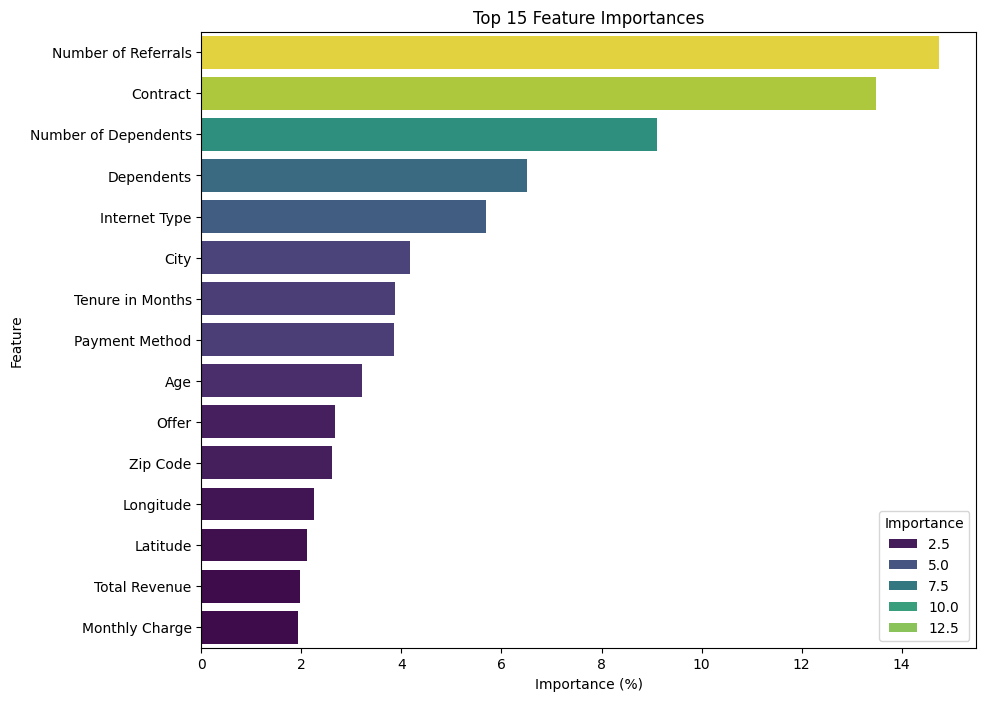

In [ ]:
# FEATURE IMPORTANCE  ---
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame for better visualization
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Plotting the top 15 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Importance', data=fi_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()

Model evaluation


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1035
           1       0.65      0.83      0.73       374

    accuracy                           0.84      1409
   macro avg       0.79      0.84      0.81      1409
weighted avg       0.86      0.84      0.84      1409


--- CONFUSION MATRIX ---


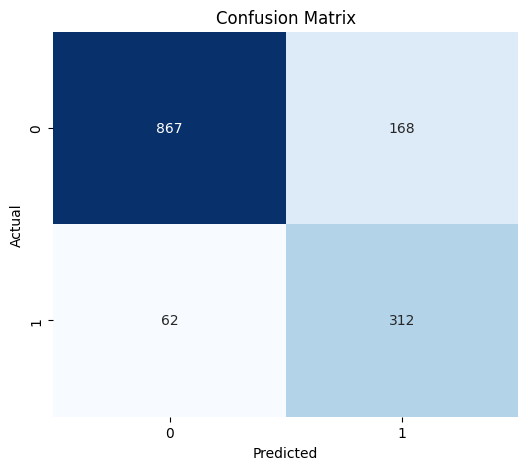


🏆 ROC-AUC Score: 0.9195


In [18]:
# Predictions
y_pred = model.predict(X_test)       # returns class labels (0 or 1)
y_prob = model.predict_proba(X_test)[:, 1] # returns probabilities for the positive class (churn=1)

# 6. Metriche
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

print("\n--- CONFUSION MATRIX ---")
# Disegniamola bella
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7. ROC-AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"\n🏆 ROC-AUC Score: {auc:.4f}")

Model Save

In [19]:
# --- Save Model ---
import joblib

MODEL_PATH = os.path.join("..", "models", "catboost_churn_v1.cbm")
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# CatBoost ha il suo metodo nativo .save_model()
model.save_model(MODEL_PATH)
print(f"💾 Model Saved into: {MODEL_PATH}")

💾 Model Saved into: ..\models\catboost_churn_v1.cbm
